In [2]:
pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.7 MB/s eta 0:00:00


Training MOGP on 36 samples (Target: AlCoCrFeNi)...
Saved Figure_11_Y1_Max_Prin_Stress.pdf
Saved Figure_12_Y2_Max_Von_Mises.pdf
Saved Figure_13_Y3_Deformation.pdf
Saved Figure_14_Max.pdf
Saved Figure_15_Heat.pdf


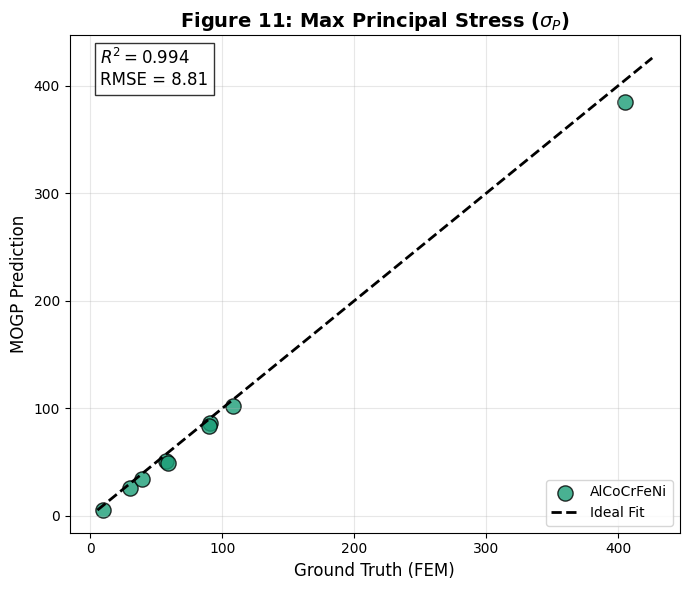

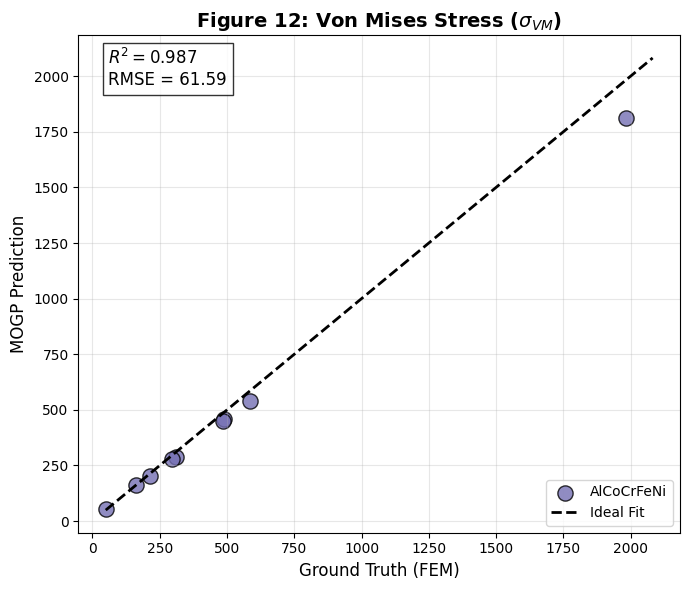

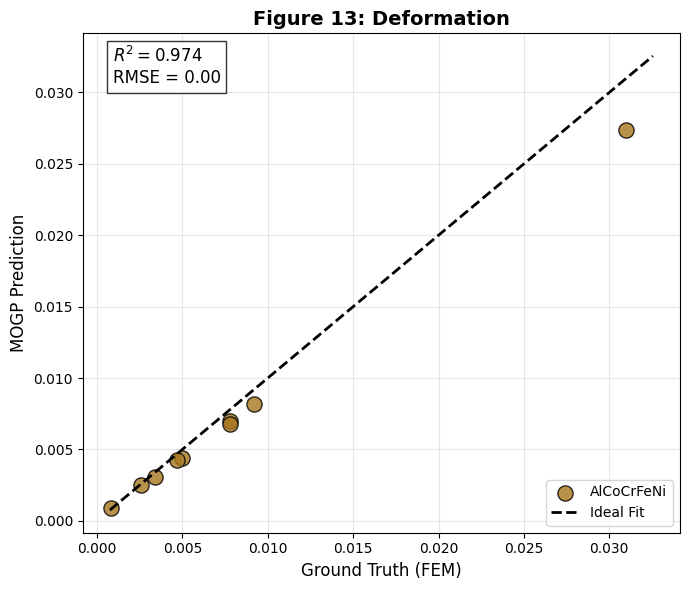

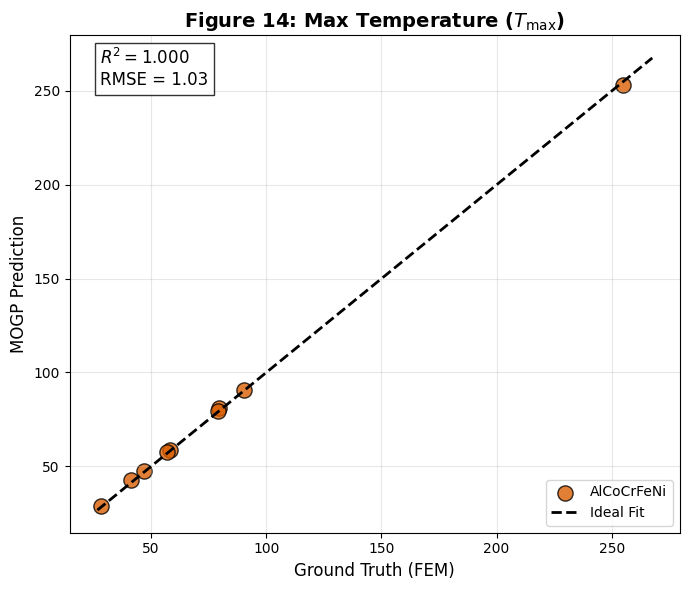

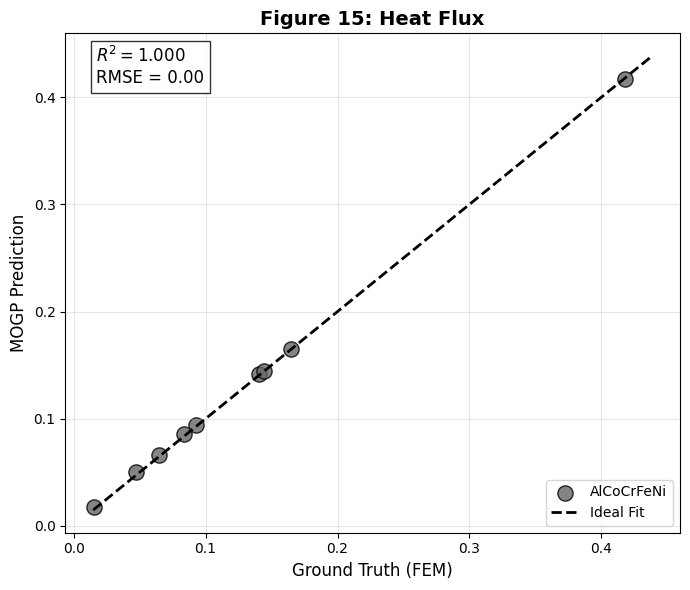

In [3]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# ==========================================
# 1. SETUP & ASSET LOADING (Source of Truth)
# ==========================================
# We load the MOGP assets to ensure we use the same Physics Dictionary
# and Scaling logic as the main optimization model.
assets = joblib.load('mogp_assets.pkl')
material_props = assets['materials']

# Define MOGP Class (Must match the architecture in mogp_assets.pkl)
class MOGP_Surrogate(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MOGP_Surrogate, self).__init__(train_x, train_y, likelihood)
        # Mean: Constant mean for each task
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=5
        )
        # Covariance: ICM Kernel (Spatial * Task Correlation)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=6)
            ),
            num_tasks=5, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# ==========================================
# 2. DATA INGESTION & PROCESSING
# ==========================================
csv_content = """Run,Material,Power_W/mm2,Speed_mm/s,Radius_mm,Y1_Max_Prin_Stress (MPa),Y2_Max_Von_Mises,Y3_Deformation mm,Max Temp,Heat flux
1,CoCrFeNiMn ,137.27,5.31,1.44,355.95,1360.2,0.0172,255.24,0.4193
2,CoCrFeNiMn ,260.59,39.51,1.11,43.22,215.36,0.0027,58.48,0.0933
3,CoCrFeNiMn ,183.35,21.1,1.22,70.385,339.24,0.0042,79.584,0.1412
4,CoCrFeNiMn ,56.31,32.79,0.89,7.3,36.37,0.0005,28.17,0.0158
5,CoCrFeNiMn ,86.3,22.69,1.06,22.986,112.5,0.0014,41.09,0.0474
6,CoCrFeNiMn ,217.8,33.32,1.4,67.52,336.46,0.0042,78.97,0.1449
7,CoCrFeNiMn ,289.23,16.03,0.92,86.55,403.25,0.005,90.65,0.1651
8,CoCrFeNiMn ,169.14,49.17,1.27,29.557,147.42,0.0018,46.94,0.0649
9,CoCrFeNiMn ,147.07,16.71,0.94,43.89,204.7,0.0025,56.82,0.0838
10,CoCrFeNiMn ,282.05,28.76,1.29,0,0,0,22,0
11,AlCoCrFeNi,137.27,5.31,1.44,405.6,1982.7,0.031,254.83,0.4175
12,AlCoCrFeNi,260.59,39.51,1.11,57.721,310.92,0.005,58.41,0.093
13,AlCoCrFeNi,183.35,21.1,1.22,90.92,490.46,0.0078,79.47,0.1407
14,AlCoCrFeNi,56.31,32.79,0.89,9.65,51.98,0.0008,28.09,0.0156
15,AlCoCrFeNi,86.3,22.69,1.06,30.148,162.61,0.0026,41.06,0.0472
16,AlCoCrFeNi,217.8,33.32,1.4,90.2,485.68,0.0078,78.86,0.1444
17,AlCoCrFeNi,289.23,16.03,0.92,108.03,583.96,0.0092,90.52,0.1645
18,AlCoCrFeNi,169.14,49.17,1.27,39.49,212.61,0.0034,46.9,0.0646
19,AlCoCrFeNi,147.07,16.71,0.94,58.84,296.28,0.0047,56.75,0.0835
20,AlCoCrFeNi,282.05,28.76,1.29,0,0,0,22,0
21,FeCrNiTiAl,137.27,5.31,1.44,404.89,1980.9,0.0311,254.88,0.4171
22,FeCrNiTiAl,260.59,39.51,1.11,54.462,310.64,0.005,58.42,0.093
23,FeCrNiTiAl,183.35,21.1,1.22,58.788,490.1,0.0078,79.48,0.1406
24,FeCrNiTiAl,56.31,32.79,0.89,9.1938,52.51,0.0008,28.16,0.0158
25,FeCrNiTiAl,86.3,22.69,1.06,28.446,162.46,0.0026,41.06,0.0472
26,FeCrNiTiAl,217.8,33.32,1.4,85.11,485.24,0.0078,78.87,0.1444
27,FeCrNiTiAl,289.23,16.03,0.92,101.94,583.43,0.0093,90.532,0.1644
28,FeCrNiTiAl,169.14,49.17,1.27,37.258,212.41,0.0034,46.9,0.0646
29,FeCrNiTiAl,147.07,16.71,0.94,51.748,296.01,0.0047,56.76,0.0834
30,FeCrNiTiAl,282.05,28.76,1.29,0,0,0,22,0
31,NbSiTaTiZr,137.27,5.31,1.44,402.62,1985.1,0.0309,255.76,0.4206
32,NbSiTaTiZr,260.59,39.51,1.11,53.92,311.33,0.0049,58.57,0.0936
33,NbSiTaTiZr,183.35,21.1,1.22,70.41,407.24,0.0065,69.87,0.1175
34,NbSiTaTiZr,56.31,32.79,0.89,9.01,52.05,0.0008,28.12,0.0157
35,NbSiTaTiZr,86.3,22.69,1.06,24.83,134.91,0.0022,37.77,0.0326
36,NbSiTaTiZr,217.8,33.32,1.4,84.27,486.33,0.0077,79.1,0.1453
37,NbSiTaTiZr,289.23,16.03,0.92,100.84,584.51,0.0092,90.78,0.1654
38,NbSiTaTiZr,169.14,49.17,1.27,36.89,212.89,0.0034,47,0.065
39,NbSiTaTiZr,147.07,16.71,0.94,51.19,296.55,0.0047,56.88,0.0839
40,NbSiTaTiZr,282.05,28.76,1.29,0,0,0,22,0
41,HfNbTiZr,137.27,5.31,1.44,404.99,1990.7,0.0311,256.07,0.4218
42,HfNbTiZr,260.59,39.51,1.11,55.88,312.25,0.005,58.62,0.0938
43,HfNbTiZr,183.35,21.1,1.22,87.98,492.33,0.0078,79.77,0.1418
44,HfNbTiZr,56.31,32.79,0.89,9.34,52.2,0.0008,28.12,0.0157
45,HfNbTiZr,86.3,22.69,1.06,29.182,163.3,0.0026,41.165,0.0476
46,HfNbTiZr,217.8,33.32,1.4,87.193,487.08,0.0078,79.1,0.1455
47,HfNbTiZr,289.23,16.03,0.92,104.53,586.2,0.0093,90.88,0.1658
48,HfNbTiZr,169.14,49.17,1.27,38.227,213.52,0.0034,47.04,0.0652
49,HfNbTiZr,147.07,16.71,0.94,53.06,297.41,0.0047,56.93,0.0841
50,HfNbTiZr,282.05,28.76,1.29,0,0,0,22,0
"""
df = pd.read_csv(io.StringIO(csv_content))
df['Material'] = df['Material'].str.strip()
df_clean = df[(df['Y2_Max_Von_Mises'] > 1e-6) & (df['Heat flux'] > 1e-6)].copy()

# Feature Embedding (Using Source of Truth)
props_df = pd.DataFrame(
    df_clean['Material'].map(material_props).tolist(),
    index=df_clean.index, columns=['Density', 'Conductivity', 'Cp']
)
X_raw = pd.concat([df_clean[['Power_W/mm2', 'Speed_mm/s', 'Radius_mm']], props_df], axis=1)
y_raw = df_clean[['Y1_Max_Prin_Stress (MPa)', 'Y2_Max_Von_Mises', 'Y3_Deformation mm', 'Max Temp', 'Heat flux']]

# ==========================================
# 3. ZERO-SHOT SPLIT (Hold Out AlCoCrFeNi)
# ==========================================
target_material = "AlCoCrFeNi"
train_mask = df_clean['Material'] != target_material
test_mask = df_clean['Material'] == target_material

X_train, y_train = X_raw[train_mask], y_raw[train_mask]
X_test, y_test = X_raw[test_mask], y_raw[test_mask]

# Scale Data
x_scaler = MinMaxScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_tr_tens = torch.tensor(x_scaler.transform(X_train), dtype=torch.float32)
y_tr_tens = torch.tensor(y_scaler.transform(y_train), dtype=torch.float32)
X_te_tens = torch.tensor(x_scaler.transform(X_test), dtype=torch.float32)

# ==========================================
# 4. TRAIN MOGP (The "Glorified" Model)
# ==========================================
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=5)
model = MOGP_Surrogate(X_tr_tens, y_tr_tens, likelihood)

model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

print(f"Training MOGP on {len(X_train)} samples (Target: {target_material})...")
for i in range(150): # 150 epochs for robust convergence
    optimizer.zero_grad()
    output = model(X_tr_tens)
    loss = -mll(output, y_tr_tens)
    loss.backward()
    optimizer.step()

# ==========================================
# 5. PREDICT & PLOT (Figures 11-15)
# ==========================================
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    dist = likelihood(model(X_te_tens))
    means_sc = dist.mean.numpy()
    # Unscale predictions to real units
    means_real = y_scaler.inverse_transform(means_sc)

# Metrics & Plotting
outputs = y_raw.columns.tolist()
colors = ['#1B9E77', '#7570B3', '#A6761D', '#D95F02', '#666666']
plot_titles = [
    r"Figure 11: Max Principal Stress ($\sigma_P$)",
    r"Figure 12: Von Mises Stress ($\sigma_{VM}$)",
    r"Figure 13: Deformation",
    r"Figure 14: Max Temperature ($T_{\max}$)",
    r"Figure 15: Heat Flux"
]

for i, col in enumerate(outputs):
    y_true = y_test[col].values
    y_pred = means_real[:, i]

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(y_true, y_pred, color=colors[i], s=120, edgecolors='k', alpha=0.8, label=f'{target_material}')

    # Ideal Line
    min_val = min(y_true.min(), y_pred.min()) * 0.95
    max_val = max(y_true.max(), y_pred.max()) * 1.05
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Fit')

    # Stats Box
    ax.text(0.05, 0.9, f"$R^2 = {r2:.3f}$\nRMSE = {rmse:.2f}", transform=ax.transAxes,
            fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    ax.set_title(plot_titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel("Ground Truth (FEM)", fontsize=12)
    ax.set_ylabel("MOGP Prediction", fontsize=12)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

    safe_name = col.split(' ')[0].replace("/", "")
    plt.tight_layout()
    plt.savefig(f"Figure_{11+i}_{safe_name}.pdf", dpi=300)
    print(f"Saved Figure_{11+i}_{safe_name}.pdf")